# Introduction

The **[Pima](https://en.wikipedia.org/wiki/Pima_people)** are a group of **Native Americans** living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, because of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity, made them develop **the highest prevalence of type 2 diabetes** and for this reason they have been subject of many studies.

## Dataset

The dataset includes data from **768** women with **8** characteristics, in particular:

1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)

The last column of the dataset indicates if the person has been diagnosed with diabetes (1) or not (0)

### Source

The original dataset is available at **UCI Machine Learning Repository** and can be downloaded from this address: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

## The problem

The type of dataset and problem is a classic **supervised binary classification**. Given a number of elements all with certain characteristics (features), we want to build a machine learning model to identify people affected by type 2 diabetes.

To solve the problem we will have to analyse the data, do any required transformation and normalisation, apply a machine learning algorithm, train a model, check the performance of the trained model and iterate with other algorithms until we find the most performant for our type of dataset.

# Imports and configuration

In [82]:
# We import the libraries needed to read the dataset
import os
import pandas as pd
import numpy as np

In [83]:
# We placed the dataset under datasets/ sub folder
DATASET_PATH = 'datasets/'

# Load the dataset

In [84]:
# We read the data from the CSV file
data_path = os.path.join(DATASET_PATH, 'pima-indians-diabetes.csv')
dataset = pd.read_csv(data_path, header=None)

# Because thr CSV doesn't contain any header, we add column names 
# using the description from the original dataset website
dataset.columns = [
    "NumTimesPrg", "PlGlcConc", "BloodP",
    "SkinThick", "TwoHourSerIns", "BMI",
    "DiPedFunc", "Age", "HasDiabetes"]

# Inspect the Dataset

In [85]:
# Check the shape of the data: we have 768 rows and 9 columns:
# the first 8 columns are features while the last one
# is the supervised label (1 = has diabetes, 0 = no diabetes)
dataset.shape

(768, 9)

In [86]:
# Visualise a table with the first rows of the dataset, to
# better understand the data format
dataset.head()

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data correlation matrix



The correlation matrix is an important tool to understand the correlation between the different characteristics. The values range from -1 to 1 and the closer a value is to 1 the bettere correlation there is between two characteristics. Let's calculate the correlation matrix for our dataset.

In [87]:
corr = dataset.corr()
corr

,NumTimesPrg,PlGlcConc,BloodP,SkinThick,TwoHourSerIns,BMI,DiPedFunc,Age,HasDiabetes
NumTimesPrg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
PlGlcConc,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodP,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThick,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
TwoHourSerIns,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiPedFunc,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
HasDiabetes,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


I'm not a doctor and I don't have any knowledge of medicine, but from the data I can guess that **the greater the age or the BMI of a patient is, the greater probabilities are the patient can develop type 2 diabetes**.

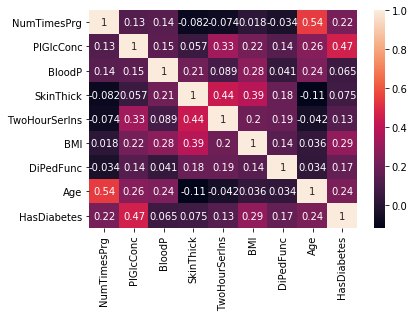

In [88]:
%matplotlib inline
import seaborn as sns
sns.heatmap(corr, annot = True)

# Visualise the Dataset

Visualising the data is an important step of the data analysis. With a graphical visualisation of the data we have a better understanding of the various features values distribution: for example we can understand what's the average age of the people or the average BMI etc...

We could of course limit our inspection to the table visualisation, but we could miss important things that may affect our model precision.

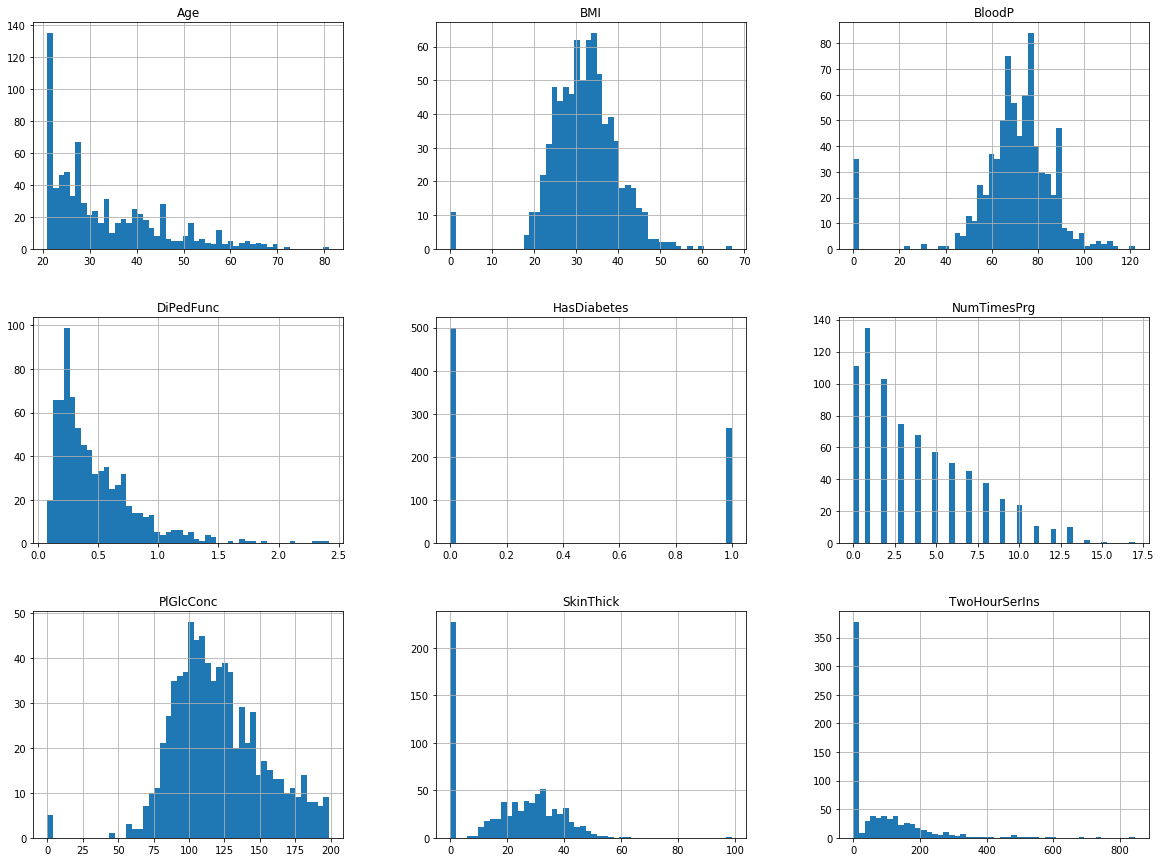

In [89]:
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20, 15))
plt.show()

An important thing I notice in the dataset (and that wasn't obvious at the beginning) is the fact that some people have **null (zero) values** for some of the features: it's not quite possible to have 0 as BMI or for the blood pressure.

How can we deal with similar values? We will see it later during the **data transformation** phase.

# Data cleaning and transformation

We have noticed from the previous analysis that some patients have missing data for some of the features. Machine learning algorithms don't work very well when the data is missing so we have to find a solution to "clean" the data we have.

The easiest option could be to eliminate all those patients with null/zero values, but in this way we would eliminate a lot of important data.

Another option is to calculate the **median** value for a specific column and substitute that value everywhere (in the same column) we have zero or null. Let's see how to apply this second method.

In [90]:
# Calculate the median value for BMI
median_bmi = dataset['BMI'].median()
# Substitute it in the BMI column of the
# dataset where values are 0
dataset['BMI'] = dataset['BMI'].replace(
    to_replace=0, value=median_bmi)

In [91]:
# Calculate the median value for BloodP
median_bloodp = dataset['BloodP'].median()
# Substitute it in the BloodP column of the
# dataset where values are 0
dataset['BloodP'] = dataset['BloodP'].replace(
    to_replace=0, value=median_bloodp)

In [92]:
# Calculate the median value for PlGlcConc
median_plglcconc = dataset['PlGlcConc'].median()
# Substitute it in the PlGlcConc column of the
# dataset where values are 0
dataset['PlGlcConc'] = dataset['PlGlcConc'].replace(
    to_replace=0, value=median_plglcconc)

In [93]:
# Calculate the median value for SkinThick
median_skinthick = dataset['SkinThick'].median()
# Substitute it in the SkinThick column of the
# dataset where values are 0
dataset['SkinThick'] = dataset['SkinThick'].replace(
    to_replace=0, value=median_skinthick)

In [94]:
# Calculate the median value for TwoHourSerIns
median_twohourserins = dataset['TwoHourSerIns'].median()
# Substitute it in the TwoHourSerIns column of the
# dataset where values are 0
dataset['TwoHourSerIns'] = dataset['TwoHourSerIns'].replace(
    to_replace=0, value=median_twohourserins)

I haven't transformed all the columns, because for some values can make sense to be zero (like "Number of times pregnant").

# Splitting the Dataset

Now that we have transformed the data we need to split the dataset in two parts: a training dataset and a test dataset. Splitting the dataset is a very important step for supervised machine learning models. Basically we are going to use the first part to train the model (ignoring the column with the pre assigned label), then we use the trained model to make predictions on new data (which is the test dataset, not part of the training set) and compare the predicted value with the pre assigned label.

In [95]:
# Split the training dataset in 80% / 20%
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    dataset, test_size=0.2, random_state=42)

In [96]:
# Separate labels from the rest of the dataset
train_set_labels = train_set["HasDiabetes"].copy()
train_set = train_set.drop("HasDiabetes", axis=1)

test_set_labels = test_set["HasDiabetes"].copy()
test_set = test_set.drop("HasDiabetes", axis=1)

# Feature Scaling

One of the most important data transformations we need to apply is the **features scaling**. Basically most of the machine learning **algorithms don't work very well if the features have a different set of values**. In our case for example the Age ranges from 20 to 80 years old, while the number of times a patient has been pregnant ranges from 0 to 17. For this reason we need to apply a proper transformation.

In [97]:
# Apply a scaler
from sklearn.preprocessing import MinMaxScaler as Scaler

scaler = Scaler()
scaler.fit(train_set)
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

## Scaled Values

In [98]:
df = pd.DataFrame(data=train_set_scaled)
df.head()

,0,1,2,3,4,5,6,7
0,0.117647,0.258065,0.489796,0.272727,0.019832,0.282209,0.096499,0.000000
1,0.529412,0.438710,0.591837,0.290909,0.019832,0.204499,0.514091,0.483333
2,0.058824,0.612903,0.224490,0.200000,0.082933,0.214724,0.245944,0.016667
3,0.000000,0.754839,0.265306,0.272727,0.019832,0.075665,0.075149,0.733333
4,0.352941,0.580645,0.571429,0.527273,0.427885,0.572597,0.068318,0.416667


# Select and train a model

It's not possible to know in advance which algorithm will work better with our dataset. We need to compare a few and select the one with the "best score".

## Comparing multiple algorithms

To compare multiple algorithms with the same dataset, there is a very nice utility in sklearn called **model_selection**. We create a list of algorithms and then we score them using the same comparison method. At the end we pick the one with the best score.

In [99]:
# Import all the algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

In [100]:
# Import the slearn utility to compare algorithms
from sklearn import model_selection

In [101]:
# Prepare an array with all the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
models.append(('LSVC', LinearSVC()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DTR', DecisionTreeRegressor()))

In [102]:
# Prepare the configuration to run the test
seed = 7
results = []
names = []
X = train_set_scaled
Y = train_set_labels

In [103]:
# Every algorithm is tested and results are
# collected and printed
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(
        model, X, Y, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.755632 (0.045675)
KNN: 0.740984 (0.049627)
NB: 0.739450 (0.062140)
SVC: 0.757271 (0.037642)
LSVC: 0.763802 (0.042701)
RFC: 0.747541 (0.054909)
DTR: 0.723030 (0.053026)


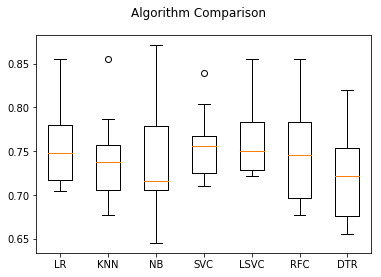

In [104]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

It looks like that using this comparison method, the most performant algorithm is **SVC**.

## Find the best parameters for SVC

The default parameters for an algorithm are rarely the best ones for our dataset. Using sklearn we can easily build a parameters grid and try all the possible combinations. At the end we inspect the `best_estimator_` property and get the best ones for our dataset.

In [105]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1.0, 10.0, 50.0],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'shrinking': [True, False],
    'gamma': ['auto', 1, 0.1],
    'coef0': [0.0, 0.1, 0.5]
}

model_svc = SVC()

grid_search = GridSearchCV(
    model_svc, param_grid, cv=10, scoring='accuracy')
grid_search.fit(train_set_scaled, train_set_labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1.0, 10.0, 50.0], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'shrinking': [True, False], 'gamma': ['auto', 1, 0.1], 'coef0': [0.0, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [106]:
# Print the bext score found
grid_search.best_score_

0.76872964169381108

## Apply the parameters to the model and train it

In [107]:
# Create an instance of the algorithm using parameters
# from best_estimator_ property
svc = grid_search.best_estimator_

# Use the whole dataset to train the model
X = np.append(train_set_scaled, test_set_scaled, axis=0)
Y = np.append(train_set_labels, test_set_labels, axis=0)

# Train the model
svc.fit(X, Y)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Make a Prediction

In [114]:
# We create a new (fake) person having the three most correated values high
new_df = pd.DataFrame([[6, 168, 72, 35, 0, 43.6, 0.627, 65]])
# We scale those values like the others
new_df_scaled = scaler.transform(new_df)

In [115]:
# We predict the outcome
prediction = svc.predict(new_df_scaled)

In [117]:
# A value of "1" means that this person is likley to have type 2 diabetes
prediction

array([1])

## Conclusion

We finally find a **score of 76%** using **SVC algorithm** and parameters optimisation. Please note that there may be still space for further analysis and optimisation, for example trying different data transformations or trying algorithms that haven't been tested yet. Once again I want to repeat that training a machine learning model to solve a problem with a specific dataset is a **try / fail / improve** process.

## Credits

First of all I need to thank my wife **Dr Daniela Ceccarelli Ceccarelli** for helping me to validate this experiment and for checking I didn't write anything wrong from a medical point of view. Then I want to thank **Dr. Jason Brownlee** for his fantastic blog which has helped me a lot to understand many concepts used here. I strongly advise you to have a look at his blog: https://machinelearningmastery.com